<h1><center></center></h1>
<h1><center>DSAI 308</center></h1>
<h1><center>Lab Exam 1 </center></h1>
<h2><center>Model C</center></h2>
<h2><center>Exam Time: 60 minutes</center></h2>

**Exam Instructions**
- You are allowed to open **TensorFlow & Keras documentation**, no other links or Colabs. Any form of cheating will result in a **ZERO GRADE**.

- **Disable AI assistance** tools during the exam.

- **Close all** unnecessary browser tabs and windows.

- Keep **your phone away** and on silent mode.

---



---



***References***

1. [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols)
2. [Keras Documentation](https://keras.io)

# **Question  -  Transfer Learning with Residual Network (Custom & Pre-trained ResNet50) on TF-citrus_leaves Dataset**

In this lab exam, you will apply **transfer learning** using the pre-trained **ResNet50** model on the **TF-citrus_leaves dataset**.

The objective is to **analyze the effects** of **transfer learning** and **data augmentation** on model performance.

-  [**TF-citrus_leaves Dataset**](https://www.tensorflow.org/datasets/catalog/citrus_leaves).
- [**ResNet50 Documentation**](https://keras.io/api/applications/resnet/#resnet50-function)



**You are required to:**

1- Load and preprocess the TF-citrus_leaves dataset using TensorFlow Datasets (TFDS).

2- **Resize images**, normalize them, and apply **data augmentation**.

3- Train **Custom Redisual Network** using the given residual_block function and analyze model's performance.

4- **Use ResNet50** and train the model on the data, analyze model's performance.

5- **Compare** the training and validation accuracy of both **models using visual plots**.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Use TensorFlow Datasets to load the TF-Flowers dataset and explore its structure.

dataset_name = "citrus_leaves"
(train_data, test_data), dataset_info = tfds.load(
    dataset_name,
    split=["train[:80%]", "train[80%:]"],  # Load 1000 training images and 200 test images
    as_supervised=True,  # Return (image, label) tuples
    with_info=True,      # Include dataset metadata
)

# Print dataset details
print("Number of Classes:", dataset_info.features["label"].num_classes)
print("Class Names:", dataset_info.features["label"].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/incomplete.TEXGS2_0.1.2/citrus_leaves-train.tfrecord*...:   …

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.
Number of Classes: 4
Class Names: ['Black spot', 'canker', 'greening', 'healthy']


In [4]:
# Check the Dataset Size & Image Shapes:

train_size = sum(1 for _ in train_data)
test_size = sum(1 for _ in test_data)
print(f"Train set size: {train_size} images")
print(f"Test set size: {test_size} images")

for image, label in train_data.take(5):
    print("Image shape:", image.shape)

Train set size: 475 images
Test set size: 119 images
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)
Image shape: (256, 256, 3)


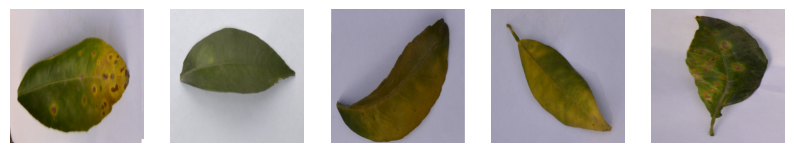

In [5]:
#  Display sample images
def show_sample_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

show_sample_images(train_data)

# **1- Preprocess Data: Resize, Normalize & Augment Images**

In [10]:
#[0.25] Define target image size (for model input)

IMG_SIZE = (150,150)

BATCH_SIZE = 32

In [11]:
# [0.5] Data Augmentation
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Convert datasets to NumPy arrays (Keras ImageDataGenerator needs NumPy arrays or file paths)
train_images, train_labels = [], []
test_images, test_labels = [], []

for image, label in train_data:
    train_images.append(tf.image.resize(image, IMG_SIZE).numpy())  # Resize images
    train_labels.append(label.numpy())  # Convert labels

for image, label in test_data:
    test_images.append(tf.image.resize(image, IMG_SIZE).numpy())  # Resize images
    test_labels.append(label.numpy())  # Convert labels

# Convert lists to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [24]:
# [0.25] Create data generators
train_generator = train_datagen.flow_from_directory(
        "/root/tensorflow_datasets/citrus_leaves/0.1.2",
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        "/root/tensorflow_datasets/citrus_leaves/0.1.2",
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


IndexError: index 0 is out of bounds for axis 0 with size 0

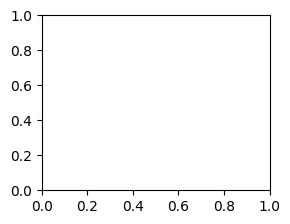

In [25]:
# Display some augmented images
x_batch, y_batch = next(train_generator)  # Get a batch of images

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_batch[i])  # Images are already normalized
    plt.axis("off")
plt.show()

# **2- Train custom residual neural network**

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#residual block
def residual_block(x, filters, stride=1, downsample=False):
    identity = x

    # First conv layer
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second conv layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection (identity path)
    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    # Add skip connection
    x = layers.add([x, identity])
    x = layers.ReLU()(x)
    return x

In [ ]:
# Build Residual Neural Network

# Input Layer
inputs = ............

# [0.25 mark]
# Initial convolution and max pool layers: Conv -> BatchNorm -> Relu -> MaxPool
x = ............(x)
x = ............(x)
x = ............(x)
x = ............(x)

# ResNet layers
# [0.25 mark] (1 residual_block + 1 residual_block with stride & downsample) x 3
x = residual_block(x, 64)
x = ............
x = ............
x = ............
x = ............
x = ............
x = ............

# [0.5 mark] Flatten -> Dense -> Dropout -> Output Layer
x = ............(x)
x = ............(x)
x = ............(x)
outputs = ............(x)

# Create the model
model_custom = models.Model(inputs, outputs)

# [0.25 mark] Compile the model with optimizer and loss function


# [0.25 mark]  Train the model and Evaluate the model on the test data
history_custom = ............

# **3- Train ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# [0.25] Use a pre-trained (ResNet50) model with frozen layers.
base_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

# [0.25] Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.frozen = True

# Add custom layers for classification
# [0.5 mark] (base_model's output) -> Flatten -> Dense -> Output layer
x = ............ # base model output
x = ............(x)  # Pooling layer
x = ............(x)  # Fully connected layer
predictions = ............(x)  # Output layer for 4 classes

# Create the model
model = models.Model(inputs=base_model.input, outputs=predictions)


# [0.25 mark] ReCompile the model with optimizer and loss function


# [0.25 mark]  ReTrain the model and Evaluate the model on the test data
history = ............

# **4-Compare Model Performances**

In [ ]:
#[0.5] Plot Training & Validation Accuracy between frozen and unfrozen models.


plt.figure(figsize=(10, 4))

# Training accuracy


# Validation accuracy


plt.show()

# **5. Discussion**

# Answer the following questions: [0.5]

Imagine you are **deploying this model** in a **real-world plant disease detection application**:

1- The model's accuracy\loss behaves like a 'zigzag' (ups and downs), what causes this behavior and how to overcome?

2- If you wanted to **classify healthy & sick plant**, what modifications would be necessary to the model?

3- If **given more time and resources**, how would you further improve your model’s performance?



**Your Answers:**

1- the length is the cause.

2- we need to use the contrastive loss as it uses the simillar and disssimillar.

3- apply a more deep model by increasing the number of params will increase the accurcy.